In [63]:
import json

with open('../../case/models/scbert/gene_vocab.json', 'r') as f:
    scbert_vocab = json.load(f)
with open('../../case/models/geneformer/gene_vocab.json', 'r') as f:
    geneformer_vocab = json.load(f)
with open('../../case/models/scgpt/vocab.json', 'r') as f:
    scgpt_vocab = json.load(f)
with open('../../case/models/scfoundation/gene_vocab.json', 'r') as f:
    scfoundation_vocab = json.load(f)
    
gene_set = set(scbert_vocab.keys()).intersection(set(geneformer_vocab.keys()))
gene_set = gene_set.intersection(scgpt_vocab.keys())
gene_set = gene_set.intersection(scfoundation_vocab.keys())
print(len(gene_set))

16585


In [64]:
import pickle

pkl_file = "/home/share/huadjyin/home/s_huluni/project/bio_model/biollm/biollm/evaluate/gene_setinfo.pkl"
# Load the pickle file
with open(pkl_file, "rb") as file:
    gene_pw_dict = pickle.load(file)


In [4]:
len(gene_pw_dict)

19477

In [65]:
genes = gene_set.intersection(set(gene_pw_dict.keys()))
len(genes)

15587

In [73]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import tqdm
from collections import defaultdict

def cal_cos_similarity(embedding_dict, threshold=99):
    a = pd.DataFrame.from_dict(embedding_dict)
    similarities = cosine_similarity(a.T)
    genes = list(a.columns)
    cutoff_value = threshold
    cutoff_value = np.percentile(similarities, threshold)
    print(cutoff_value)
    cutoff_value = 0 if cutoff_value < 0 else cutoff_value
    similarities[similarities < cutoff_value] = 0
    nodes_weight = defaultdict(list)
    nz = list(zip(*similarities.nonzero()))
    print('len gene paries: ', len(nz))
    
    for n in tqdm.tqdm(nz):
        if n[0] != n[1]:
            nodes_weight['g1'].append(genes[n[0]])
            nodes_weight['g2'].append(genes[n[1]])
            nodes_weight['score'].append(similarities[n[0], n[1]])
            # nodes_weight.append((genes[n[0]], genes[n[1]], similarities[n[0], n[1]]))
    df = pd.DataFrame(nodes_weight)
    return df

def cal_bio_jacard(scores_df, gene_pw_dict):
    res = []
    for i in scores_df.index:
        set1 = set(gene_pw_dict[scores_df.iloc[i]['g1']])
        set2 = set(gene_pw_dict[scores_df.iloc[i]['g2']])
    
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
    
        jaccard_index = intersection / union
        res.append(jaccard_index)
    scores_df['jacard_dis'] = res

    return scores_df



{'scbert': 0.05208201256479205,
 'scgpt': 0.12346761217024102,
 'scfoundation': 0.000534098729770561}

In [80]:
import pickle 
genes = list(genes)
corr_score = {}
for i in ['scbert', 'scgpt', 'scfoundation', 'geneformer']:
    with open(f'../../case/result/zero-shot/{i}_gene_emb.pk', 'rb') as f:
        emb = pickle.load(f)
    if not isinstance(emb['gene_emb'], np.ndarray):
        emb['gene_emb'] = emb['gene_emb'].cpu().detach().numpy()
    # np.random.shuffle(genes)
    # sub_genes = genes[0:1000]
    model_emb = {i: emb['gene_emb'][emb['gene_names'].index(i)] for i in genes}
    scores = cal_cos_similarity(model_emb)
    scores_df = cal_bio_jacard(scores, gene_pw_dict)
    corr = np.corrcoef(scores_df['score'].values, scores['jacard_dis'].values)
    corr_score[i] = corr[0, 1]

0.5802778601646423
len gene paries:  2429547


100%|██████████| 2429547/2429547 [00:03<00:00, 775241.02it/s]


In [107]:
corr_score

{'scbert': 0.05208201256479205,
 'scgpt': 0.12346761217024102,
 'scfoundation': 0.000534098729770561,
 'geneformer': 0.013951334791291634}

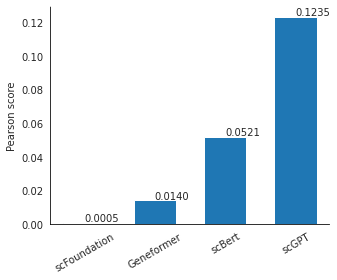

In [106]:
from matplotlib import pyplot as plt

x = ['scfoundation', 'geneformer', 'scbert', 'scgpt']
y = [corr_score[i] for i in x]
x = ['scFoundation', 'Geneformer', 'scBert', 'scGPT']
plt.figure(figsize=(5, 4))
axes_1 = plt.gca()
color_name = "black"
# axes_1.spines["top"].set_color(color_name)
axes_1.spines["bottom"].set_color(color_name)
axes_1.spines["left"].set_color(color_name)
# axes_1.spines["right"].set_color(color_name)
axes_1.patch.set_facecolor("white")
axes_1.axes.xaxis.set_visible(True)
plt.bar(x, y, width=0.6)
for i in range(len(x)):
    plt.annotate('%.4f' % y[i], xy = (x[i], y[i]), xytext=(x[i], y[i] + 0.001))
plt.xticks(rotation=30)
plt.ylabel('Pearson score')
plt.savefig('./fig4_gene_emb_corr.pdf', bbox_inches='tight')

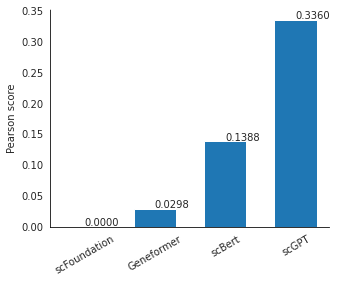

In [109]:
corr_score1 = {'scbert': 0.13881069720483408,
 'scgpt': 0.33598432810723,
 'scfoundation': 3.0390867810700032e-05,
 'geneformer': 0.0298339051030289}


x = ['scfoundation', 'geneformer', 'scbert', 'scgpt']
y = [corr_score1[i] for i in x]
x = ['scFoundation', 'Geneformer', 'scBert', 'scGPT']
plt.figure(figsize=(5, 4))
axes_1 = plt.gca()
color_name = "black"
# axes_1.spines["top"].set_color(color_name)
axes_1.spines["bottom"].set_color(color_name)
axes_1.spines["left"].set_color(color_name)
# axes_1.spines["right"].set_color(color_name)
axes_1.patch.set_facecolor("white")
axes_1.axes.xaxis.set_visible(True)
plt.bar(x, y, width=0.6)
for i in range(len(x)):
    plt.annotate('%.4f' % y[i], xy = (x[i], y[i]), xytext=(x[i], y[i] + 0.001))
plt.xticks(rotation=30)
plt.ylabel('Pearson score')
plt.savefig('./fig4_gene_emb_corr_1.pdf', bbox_inches='tight')

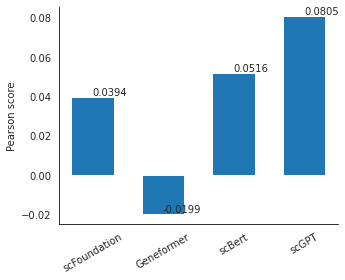

In [2]:
# gene-express embedding
from matplotlib import pyplot as plt


corr_score1 = {'scbert': 0.05155456850986517,
 'scgpt': 0.08049992395785417,
 'scfoundation': 0.03935163101523745,
 'geneformer': -0.019913766772582435}

x = ['scfoundation', 'geneformer', 'scbert', 'scgpt']
y = [corr_score1[i] for i in x]
x = ['scFoundation', 'Geneformer', 'scBert', 'scGPT']
plt.figure(figsize=(5, 4))
axes_1 = plt.gca()
color_name = "black"
# axes_1.spines["top"].set_color(color_name)
axes_1.spines["bottom"].set_color(color_name)
axes_1.spines["left"].set_color(color_name)
# axes_1.spines["right"].set_color(color_name)
axes_1.patch.set_facecolor("white")
axes_1.axes.xaxis.set_visible(True)
plt.bar(x, y, width=0.6)
for i in range(len(x)):
    plt.annotate('%.4f' % y[i], xy = (x[i], y[i]), xytext=(x[i], y[i] + 0.001))
plt.xticks(rotation=30)
plt.ylabel('Pearson score')
plt.savefig('./fig4_gene_exp_emb_corr.pdf', bbox_inches='tight')
